In [1]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from diffSPH.v2.modules.viscosity import computeViscosityParameter, setViscosityParameters
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime
from diffSPH.v2.util import computeStatistics
import tomli

In [2]:
configurationFile = './configurations/01_tgv.toml'

with open(configurationFile, 'r') as f:
    config = f.read()

config = tomli.loads(config)

In [3]:
config['domain']

{'adjustParticle': False, 'adjustDomain': False, 'dim': 2, 'periodic': True}

In [4]:
nx_initial = 128
dx = 2 / nx_initial

boundary_width = 5
nx = nx_initial + 2 * boundary_width
L = 1
u_mag = 5
k = 1 * np.pi
TGV_override = False
targetRe = 1000

config['domain']['minExtent'] = [-1. - boundary_width * dx,-1. - boundary_width * dx]
config['domain']['maxExtent'] =  [1. + boundary_width * dx,1. + boundary_width * dx]
config['domain']['periodic'] = False

config['boundary']['active'] = True

config['particle'] = {'nx' : nx}
config['fluid'] = {'cs' : u_mag * 10}
config['compute'] = {'device': 'cuda', 'checkNaN': True}
# config['compute'] = {'device': 'cpu', 'checkNaN': True}


config = parseDefaultParameters(config)
config = parseModuleParameters(config)
setViscosityParameters(config, targetRe, L, u_mag)
config['diffusion']['alpha'] = 0.01
config['diffusion']['pi-switch']=False
config['gravity']['active'] = False
# config['EOS']['type'] = 'stiffTait'

print(rf'Re = {config["diffusion"]["Re"]}, $\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$, $\alpha = {config["diffusion"]["alpha"]}$')


Re = 1000.0, $\nu_{sph} = 0.009999999776482582$, $\alpha = 0.01$


In [5]:
config['particle']['dx'] - dx

tensor(0., device='cuda:0')

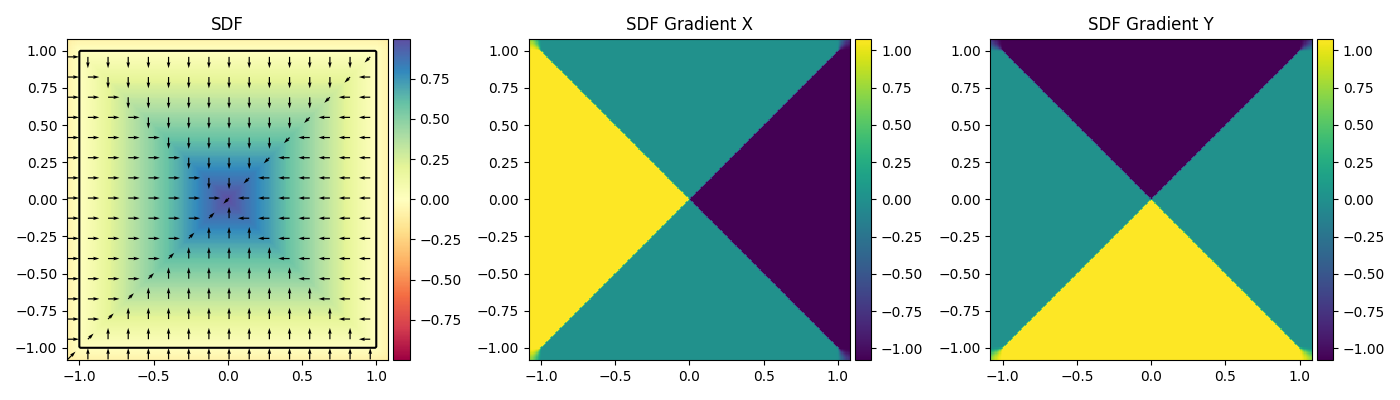

In [6]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict

ngrid = 255
x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('polygon')['function'](points, torch.tensor([[0.5,0.5],[0.5,-0.5],[-0.5,-0.5],[-0.5,0.5]]))
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/3,1/3]).to(points.device))
inner = lambda points: getSDF('box')['function'](points, torch.tensor([1,1]).to(points.device))
outer = lambda points: getSDF('box')['function'](points, torch.tensor([1 + config['particle']['dx'] * boundary_width,1 + config['particle']['dx'] * boundary_width]).to(points.device))


translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)

outer = operatorDict['invert'](outer)
sdf = operatorDict['union'](inner, outer)
sdf = operatorDict['invert'](inner)

# circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# sdf = operatorDict['twist'](sdf, 0.5)
# sdf = operatorDict['shell'](sdf, 0.125)
sdf = sdf
plotSDF(sdf(torch.clone(points),), X, Y, 2, 2)

In [7]:
from torch.profiler import profile, record_function, ProfilerActivity
from diffSPH.v2.modules.inletOutlet import processInlet, processOutlet, processForcing
from diffSPH.v2.plotting import plotRegions
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict
from diffSPH.v2.sampling import find_contour

In [8]:


ngrid = 255
x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1/2]).to(points.device))
inletSDF = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1]).to(points.device))
outletSDF = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/4,1.5]).to(points.device))
outletRegion = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/4,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

inner = lambda points: getSDF('box')['function'](points, torch.tensor([1,1]).to(points.device))
outer = lambda points: getSDF('box')['function'](points, torch.tensor([1 + config['particle']['dx'] * boundary_width,1 + config['particle']['dx'] * boundary_width]).to(points.device))
outer = operatorDict['invert'](outer)
sdf = operatorDict['union'](inner, outer)
boundary_sdf = operatorDict['invert'](inner)


fluid_sdf = lambda points: getSDF('box')['function'](points, torch.tensor([1,1]).to(points.device))
# fluid_sdf = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/2, - 1/2]))


regions = [
    # {
    #     'sdf': inletSDF,
    #     'type': 'inlet',
    #     'velocity': torch.tensor([1,0.]),
    #     'particles': sampleParticles(config, sdfs = [inletSDF])[0],
    #     'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },
    # {
    #     'sdf': inletSDF,
    #     'type': 'forcing',
    #     'forcingMode': 'immediate',
    #     'velocity': torch.tensor([1,0.]),
    #     'particles': sampleParticles(config, sdfs = [inletSDF])[0],
    #     'contour': find_contour(inletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },{
    #     'sdf': outletSDF,
    #     'type': 'outlet',
    #     'velocity': torch.tensor([0.,0.]),
    #     'particles': sampleParticles(config, sdfs = [outletSDF])[0],
    #     'contour': find_contour(outletSDF(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },{
    #     'sdf': outletRegion,
    #     'type': 'mirror',
    #     'velocity': torch.tensor([0.,0.]),
    #     'particles': sampleParticles(config, sdfs = [outletRegion])[0],
    #     'contour': find_contour(outletRegion(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    # },
    {
        'sdf': boundary_sdf,
        'type': 'boundary',
        'velocity': torch.tensor([0.,0.]),
        # 'particles': sampleParticles(config, sdfs = [boundary_sdf])[0],
        'contour': find_contour(boundary_sdf(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    },{
        'sdf': fluid_sdf,
        'type': 'fluid',
        'velocity': torch.tensor([0.,0.]),
        # 'particles': sampleParticles(config, sdfs = [fluid_sdf])[0],
        'contour': find_contour(fluid_sdf(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    }
    ]

config['regions'] = regions

# fig, axis = plt.subplots(1,2, figsize = (15,5), squeeze = False)
# setPlotBaseAttributes(axis[0,0], config)
# # setPlotBaseAttributes(axis[0,1], config)

# # plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,0])


In [9]:
from diffSPH.v2.sampling import *

In [10]:

def filterPotentialField(sdf, noiseState, config, kind = 'divergenceFree'):
    if kind == 'divergenceFree':
        return rampDivergenceFree(noiseState['positions'], noiseState['potential'], sdf, offset = noiseState['supports'], d0 = noiseState['supports'])
    else:
        return rampOrthogonal(noiseState['positions'], noiseState['potential'], sdf, offset = -config['particle']['dx'] / 2, d0 = noiseState['supports'])

In [11]:

# particleState['supports'] - config['particle']['support']

In [12]:
def sampleNoisyParticles(noiseConfig, config, sdfs = [], randomizeParticles = False):
    particlesA, volumeA = sampleRegular(config['particle']['dx'], config['domain']['dim'], config['domain']['minExtent'], config['domain']['maxExtent'], config['kernel']['targetNeighbors'], config['simulation']['correctArea'], config['kernel']['function'])
    particlesA = particlesA.to(config['compute']['device'])
    volumeA = volumeA.to(config['compute']['device'])
    
    area = (4 / config['particle']['nx']**2)
    area = volumeA
    grid, noiseSimplex = sampleNoise(noiseConfig)

    noiseState = {}
    noiseState['numParticles'] = particlesA.shape[0]
    # noiseState['timestep'] = 0
    # noiseState['time'] = 0.
    # noiseState['dt'] = config['timestep']['dt']
    noiseState['positions'] = particlesA
    noiseState['areas'] = particlesA.new_ones(particlesA.shape[0]) * area
    noiseState['pressures'] = particlesA.new_zeros(particlesA.shape[0])
    noiseState['divergence'] = particlesA.new_zeros(particlesA.shape[0])
    noiseState['masses'] = noiseState['areas'] * config['fluid']['rho0']
    noiseState['supports'] = volumeToSupport(area, config['kernel']['targetNeighbors'], config['domain']['dim']) * particlesA.new_ones(particlesA.shape[0])
    noiseState['index'] = torch.arange(particlesA.shape[0], device = particlesA.device)
    noiseState['densities'] = particlesA.new_ones(particlesA.shape[0]) * config['fluid']['rho0'] 
    noiseState['velocities'] = particlesA.new_zeros(particlesA.shape[0], config['domain']['dim'])
    noiseState['accelerations'] = particlesA.new_zeros(particlesA.shape[0], config['domain']['dim'])
    if len(sdfs) > 0:
        noiseState['distances'] = particlesA.new_ones(particlesA.shape[0]) * np.inf

    if randomizeParticles:
        baseShiftingConfig = copy.deepcopy(config['shifting'])

        config['shifting']['solver'] = 'BiCGStab_wJacobi'
        # config['shifting']['solver'] = 'BiCGStab'
        config['shifting']['maxIterations'] = 64
        config['shifting']['freeSurface'] = False
        config['shifting']['summationDensity'] = False
        config['shifting']['scheme'] = 'IPS'
        config['shifting']['maxSolveIter'] = 128
        config['shifting']['initialization'] = 'zero'
        config['shifting']['threshold'] = 0.5

        positions = torch.rand(noiseState['positions'].shape, device = noiseState['positions'].device) * 2 - 1
        shiftState = {
                'positions': positions,
                'areas': noiseState['areas'],
                'densities': noiseState['densities'],\
                'numParticles': noiseState['numParticles'],
                'velocities': noiseState['velocities'],
                'masses': noiseState['masses'],
                'supports': noiseState['supports'],
            }
        dx, states = solveShifting({
            'fluid':shiftState
        }, config)
        shiftState['positions'] = positions + dx

        config['shifting'] = baseShiftingConfig

        x = shiftState['positions'].clone()

        periodic = config['domain']['periodicity']
        minDomain = config['domain']['minExtent']
        maxDomain = config['domain']['maxExtent']
        periodicity = torch.tensor([False] * x.shape[1], dtype = torch.bool).to(x.device)
        if isinstance(periodic, torch.Tensor):
            periodicity = periodic
        if isinstance(periodic, bool):
            periodicity = torch.tensor([periodic] * x.shape[1], dtype = torch.bool).to(x.device)

        mod_positions = torch.stack([x[:,i] if not periodic_i else torch.remainder(x[:,i] - minDomain[i], maxDomain[i] - minDomain[i]) + minDomain[i] for i, periodic_i in enumerate(periodicity)], dim = 1)
        lin_x = (mod_positions[:,0] - minDomain[0]) / (maxDomain[0] - minDomain[0])
        lin_y = (mod_positions[:,1] - minDomain[1]) / (maxDomain[1] - minDomain[1])

        gridDim = 128 // 2
        linearIndex = (torch.round(lin_x * gridDim) + torch.round(lin_y * gridDim) * gridDim).to(torch.int32)
        sortedIndices = torch.argsort(linearIndex)
        sortedPositions = mod_positions[sortedIndices]
        shiftState['positions'] = sortedPositions

        _, noiseNeighbors = neighborSearch(shiftState, noiseState, config)

        noise = noiseSimplex.flatten().to(particlesA.device)
        noiseState['potential'] = sphOperationStates(noiseState, shiftState, (noise, noise), operation = 'interpolate', neighborhood = noiseNeighbors)
        noiseState['positions'] = shiftState['positions']



    else:
        noiseState['potential'] = noiseSimplex.flatten().to(particlesA.device)




    # mask = torch.ones_like(noiseState['areas'], dtype = torch.bool)
    # fluid_sdfs = [sdf['sdf'] for sdf in sdfs if sdf['type'] == 'fluid' ]   
    # mask = None
    # if len(fluid_sdfs) > 0:
    #     mask = torch.zeros_like(noiseState['areas'], dtype = torch.bool)

    #     for sdf_func in fluid_sdfs:
    #         _, maskA, sdfValues, _ = filterParticlesWithSDF(particlesA, sdf_func, noiseState['supports'][0], -1e-4)
    #         mask = mask | maskA
    #         noiseState['distances'] = torch.min(noiseState['distances'], sdfValues)
    #     mask = mask.to(config['compute']['device'])
    # noiseState['velocities'][~mask, :] = 0

    samplings = None
    if samplings is None:   
        samplings = ['regular' for _ in sdfs]
    if not isinstance(samplings, List):
        samplings = [samplings for _ in sdfs]

    boundary_sdfs = [sdf['sdf'] for sdf in sdfs if sdf['type'] == 'boundary' ]   
    
    boundaryParticles, boundaryVolumes, boundaryDistances, boundaryNormals, boundaryBodyIDs, fluidMask = sampleBoundaryParticles(noiseState, boundary_sdfs, config, samplings)
    for k in noiseState.keys():
        if isinstance(noiseState[k], torch.Tensor):
            noiseState[k] = noiseState[k][fluidMask]
    noiseState['numParticles'] = noiseState['positions'].shape[0]
            
    _, fluidNeighborhood = neighborSearch(noiseState, noiseState, config)

    noiseState['neighborhood'] = fluidNeighborhood
    # printState(noiseState)
    
    # printState(noiseState)

    # for sdf in boundary_sdfs:
    #     # _, maskA, _, _ = filterParticlesWithSDF(particlesA, operatorDict['invert'](sdf), config['particle']['support'], -1e-4)
        # noiseState['potential'] = filterPotentialField(operatorDict['invert'](sdf), noiseState, config, kind = 'divergenceFree')
        # noiseState['potential'] = filterPotentialField(sdf, noiseState, config, kind = 'divergenceFree')


    noiseState['velocities'], noiseState['divergence'] = sampleVelocityField(noiseState, noiseState['neighborhood'])
    # if mask is None:
        # mask = torch.ones_like(noiseState['potential'], dtype = torch.bool)
    # for sdf_func in boundary_sdfs:
        # _, maskA, _, _ = filterParticlesWithSDF(particlesA, operatorDict['invert'](sdf), config['particle']['support'], -1e-4)
        # _, maskA, _, _ = filterParticlesWithSDF(particlesA, sdf, config['particle']['support'], -1e-4)
        # mask = mask & maskA
    # noiseState['velocities'][~mask, :] = 0

    _, noiseState['numNeighbors'] = countUniqueEntries(fluidNeighborhood['indices'][0], noiseState['positions'])

    return noiseState, None

In [13]:
from diffSPH.v2.sampling import sampleParticles, processBoundarySDFs
from diffSPH.v2.finiteDifference import centralDifferenceStencil, continuousGradient

particleState, mask = sampleParticles(config, sdfs = [region['sdf'] for region in regions if region['type'] == 'fluid'])
particleState, mask = sampleNoisyParticles(config['noise'], config, sdfs = regions)
boundaryState = processBoundarySDFs(particleState, config, [region['sdf'] for region in regions if region['type'] == 'boundary'], 'regular')


config['timestep']['dt'] = 5e-4
s = 2
perennialState = {
    'fluid': copy.deepcopy(particleState),
    'boundary': boundaryState,
    'time': 0.0,
    'timestep': 0,
    'dt': config['timestep']['dt'],
    'uidCounter': particleState['numParticles']
}

u = 1

perennialState['fluid']['positions'] += torch.normal(mean = 0, std = config['particle']['dx'] * 0.01, size = [perennialState['fluid']['numParticles'], 2], device = perennialState['fluid']['positions'].device)
perennialState['boundary']['positions'] += torch.normal(mean = 0, std = config['particle']['dx'] * 0.01, size = [perennialState['boundary']['numParticles'], 2], device = perennialState['boundary']['positions'].device)


p = perennialState['boundary']['positions']
# inner()
sdf = inner
h = config['particle']['support']

stencil = centralDifferenceStencil(1, 2)
stencil = stencil.to(p.device)
sdfValues = sdf(p.cpu()).to(p.device)

sdfGradient = continuousGradient(sdf, p, stencil, 0.2 * h, 1)
perennialState['boundary']['normals'] = -sdfGradient / (torch.linalg.norm(sdfGradient, dim = 1, keepdim = True) + 1e-6)
perennialState['boundary']['distances'] = sdfValues

In [14]:
from diffSPH.v2.plotting import visualizeParticleQuantity

In [15]:
def rampDivergenceFree(positions, noise, sdf_func, offset, d0 = 0.25):
    sdf = sdf_func(positions)
#     r = sdf / d0 /2  + 0.5
    r = (sdf - offset) / d0 / 0.5 - 1
#     ramped = r * r * (3 - 2 * r)
    ramped = 15/8 * r - 10/8 * r**3 + 3/8 * r**5
#     ramped = r
    ramped[r >= 1] = 1
    ramped[r <= -1] = -1
#     ramped[r <= 0] = 0
#     ramped[r <= -1] = -1
    
    return (ramped /2 + 0.5) * (noise)

In [16]:
fluid_sdf = lambda points: getSDF('box')['function'](points, torch.tensor([1,1]).to(points.device))

In [17]:
_, boundaryNeighborhood = neighborSearch(perennialState['fluid'], perennialState['boundary'], config)

In [18]:
divergence = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (perennialState['fluid']['velocities'], perennialState['fluid']['velocities']), operation = 'divergence', neighborhood = perennialState['fluid']['neighborhood'])

divergence += sphOperationStates(perennialState['fluid'], perennialState['boundary'], (perennialState['fluid']['velocities'], perennialState['boundary']['velocities']), operation = 'divergence', neighborhood = boundaryNeighborhood)
# divergence.shape

In [19]:

potential = perennialState['fluid']['potential']

In [20]:
def rampDivergenceFree(positions, noise, sdf_func, offset, d0 = 0.25):
    sdf = sdf_func(positions)
#     r = sdf / d0 /2  + 0.5
    r = (sdf - offset)/ d0
    r = torch.clamp(r, -1, 1)
    # return r

    # r = (sdf - offset) / d0 / 0.5 - 1


    # return -r
#     ramped = r * r * (3 - 2 * r)
    ramped = 15/8 * r - 10/8 * r**3 + 3/8 * r**5
#     ramped = r
    # ramped[r >= 1] = 1
    # ramped[r <= -1] = -1
#     ramped[r <= 0] = 0
#     ramped[r <= -1] = -1
    return ramped    
    # return (ramped /2 + 0.5) * (noise)

In [21]:
ramp = rampDivergenceFree(perennialState['fluid']['positions'], torch.ones_like(potential), boundary_sdf, offset = config['particle']['dx']/2, d0 = 10 * perennialState['fluid']['supports'])

print(ramp.min() - config['particle']['dx']/2 / config['particle']['support'])

tensor(-0.1335, device='cuda:0')


In [22]:
config['particle']['support']**2 * np.pi / (config['particle']['dx']**2)
print(config['particle']) 

{'nx': 138, 'dx': tensor(0.0156, device='cuda:0'), 'support': tensor(0.0593, device='cuda:0'), 'defaultVolume': tensor(0.0002, device='cuda:0'), 'defaultSupport': tensor(0.0593, device='cuda:0'), 'volume': tensor(0.0002, device='cuda:0'), 'smoothingLength': tensor(0.0312, device='cuda:0')}


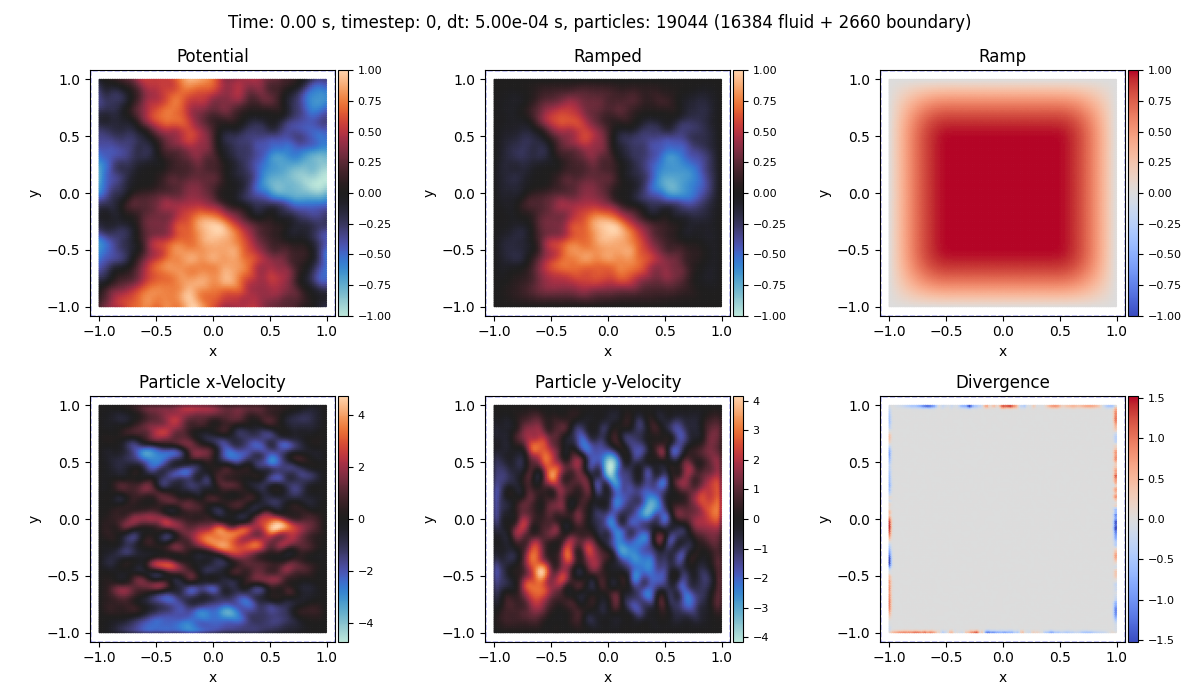

In [23]:
fig, axis = plt.subplots(2,3, figsize = (12,7), squeeze = False)
s = 1

ramped = torch.clone(potential)
# ramped[:] = 1
# ramp = rampDivergenceFree(perennialState['fluid']['positions'], torch.ones_like(potential), boundary_sdf, offset = perennialState['fluid']['supports'], d0 = perennialState['fluid']['supports'])

r = (perennialState['fluid']['positions'][:,0] - (-1)) / (config['particle']['support'] * 10)
r = torch.clamp(r, -1, 1)
ramp1 = 15/8 * r - 10/8 * r**3 + 3/8 * r**5


r = -(perennialState['fluid']['positions'][:,0] - (1)) / (config['particle']['support'] * 10)
r = torch.clamp(r, -1, 1)
ramp2 = 15/8 * r - 10/8 * r**3 + 3/8 * r**5

r = (perennialState['fluid']['positions'][:,1] - (-1)) / (config['particle']['support'] * 10)
r = torch.clamp(r, -1, 1)
ramp3 = 15/8 * r - 10/8 * r**3 + 3/8 * r**5

r = -(perennialState['fluid']['positions'][:,1] - (1)) / (config['particle']['support'] * 10)
r = torch.clamp(r, -1, 1)
ramp4 = 15/8 * r - 10/8 * r**3 + 3/8 * r**5

ramp = torch.min(torch.stack([ramp1, ramp2, ramp3, ramp4]), dim = 0).values
ramp = ramp1 * ramp2 * ramp3 * ramp4
ramped = ramped * ramp


filteredState = copy.deepcopy(perennialState)
filteredState['fluid']['potential'] = ramped

def sampleVelocityField(noiseState, neighborhood):
    gradTerm = sphOperationStates(noiseState, noiseState, (noiseState['potential'], noiseState['potential']), operation = 'gradient', gradientMode='naive', neighborhood=neighborhood)
    velocities = torch.stack([-gradTerm[:,1], gradTerm[:,0]], dim = -1)
    divergence = sphOperationStates(noiseState, noiseState, (velocities, velocities), operation = 'divergence', neighborhood=neighborhood)
    return velocities, divergence 

velocity, divergence = sampleVelocityField(filteredState['fluid'], perennialState['fluid']['neighborhood'])


divergence = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (velocity, velocity), operation = 'divergence', neighborhood = perennialState['fluid']['neighborhood'])

divergence += sphOperationStates(perennialState['fluid'], perennialState['boundary'], (velocity, perennialState['boundary']['velocities']), operation = 'divergence', neighborhood = boundaryNeighborhood)



visualizationState = prepVisualizationState(perennialState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
                                      perennialState['fluid']['potential'],
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'icefire', title = 'Potential', which = 'fluid', plotBoth = False, midPoint = 0)
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
                                    #   'velocities', 
                                      ramped,
                                      mapping = '.y', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'icefire', streamLines = False, operation = None, title = 'Ramped', plotBoth = False, which = 'fluid', midPoint = 0)
divergencePlot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
                                        #    rampDivergenceFree(perennialState['fluid']['positions'], perennialState['fluid']['potential'], boundary_sdf, 0, d0 = 0.25), 
                                        ramp,
                                        # perennialState['fluid']['potential'],
                                    #    divergence,
                                           mapping = '', s = s,
                            scaling = 'sym', gridVisualization=False, cmap = 'coolwarm', streamLines = False, operation = None, title = 'Ramp', plotBoth = False, which = 'fluid', midPoint = 0)

indexPlot = visualizeParticleQuantity(fig, axis[1,0], config, visualizationState, quantity =
                                      velocity,
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'icefire', title = 'Particle x-Velocity', which = 'fluid', plotBoth = False, midPoint = 0)
quantPlot = visualizeParticleQuantity(fig, axis[1,1], config, visualizationState, quantity = 
                                      velocity, 
                                      mapping = '.y', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'icefire', streamLines = False, operation = None, title = 'Particle y-Velocity', plotBoth = False, which = 'fluid', midPoint = 0)

divergencePlot = visualizeParticleQuantity(fig, axis[1,2], config, visualizationState, quantity = 
                                       divergence,
                                           mapping = '', s = s,
                            scaling = 'sym', gridVisualization=False, cmap = 'coolwarm', streamLines = False, operation = None, title = 'Divergence', plotBoth = False, which = 'fluid', midPoint = 0)


fig.tight_layout()

fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary)')
fig.tight_layout()

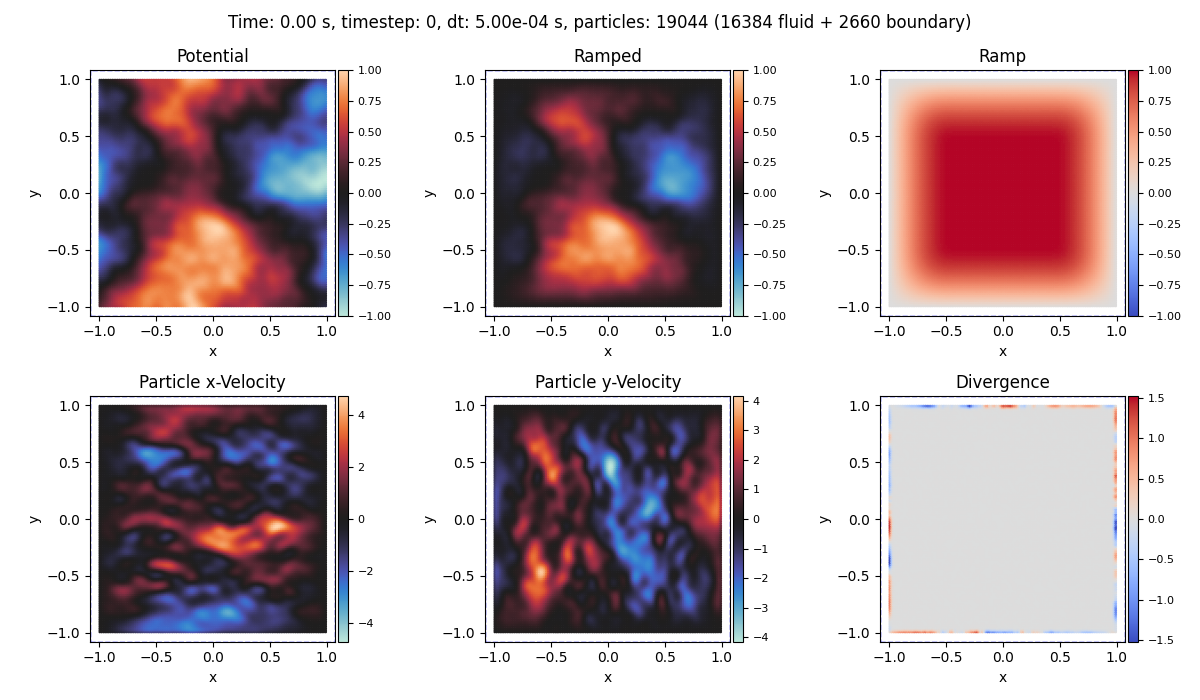

In [24]:
fig, axis = plt.subplots(2,3, figsize = (12,7), squeeze = False)
s = 1

ramped = torch.clone(potential)
# ramped[:] = 1
# ramp = rampDivergenceFree(perennialState['fluid']['positions'], torch.ones_like(potential), boundary_sdf, offset = perennialState['fluid']['supports'], d0 = perennialState['fluid']['supports'])

r = (perennialState['fluid']['positions'][:,0] - (-1)) / (config['particle']['support'] * 10)
r = torch.clamp(r, -1, 1)
ramp1 = 15/8 * r - 10/8 * r**3 + 3/8 * r**5


r = -(perennialState['fluid']['positions'][:,0] - (1)) / (config['particle']['support'] * 10)
r = torch.clamp(r, -1, 1)
ramp2 = 15/8 * r - 10/8 * r**3 + 3/8 * r**5

r = (perennialState['fluid']['positions'][:,1] - (-1)) / (config['particle']['support'] * 10)
r = torch.clamp(r, -1, 1)
ramp3 = 15/8 * r - 10/8 * r**3 + 3/8 * r**5

r = -(perennialState['fluid']['positions'][:,1] - (1)) / (config['particle']['support'] * 10)
r = torch.clamp(r, -1, 1)
ramp4 = 15/8 * r - 10/8 * r**3 + 3/8 * r**5

ramp = torch.min(torch.stack([ramp1, ramp2, ramp3, ramp4]), dim = 0).values
ramp = ramp1 * ramp2 * ramp3 * ramp4
ramped = ramped * ramp


filteredState = copy.deepcopy(perennialState)
filteredState['fluid']['potential'] = ramped

def sampleVelocityField(noiseState, neighborhood):
    gradTerm = sphOperationStates(noiseState, noiseState, (noiseState['potential'], noiseState['potential']), operation = 'gradient', gradientMode='naive', neighborhood=neighborhood)
    velocities = torch.stack([-gradTerm[:,1], gradTerm[:,0]], dim = -1)
    divergence = sphOperationStates(noiseState, noiseState, (velocities, velocities), operation = 'divergence', neighborhood=neighborhood)
    return velocities, divergence 

velocity, divergence = sampleVelocityField(filteredState['fluid'], perennialState['fluid']['neighborhood'])


divergence = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (velocity, velocity), operation = 'divergence', neighborhood = perennialState['fluid']['neighborhood'])

divergence += sphOperationStates(perennialState['fluid'], perennialState['boundary'], (velocity, perennialState['boundary']['velocities']), operation = 'divergence', neighborhood = boundaryNeighborhood)



visualizationState = prepVisualizationState(perennialState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
                                      perennialState['fluid']['potential'],
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'icefire', title = 'Potential', which = 'fluid', plotBoth = False, midPoint = 0)
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
                                    #   'velocities', 
                                      ramped,
                                      mapping = '.y', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'icefire', streamLines = False, operation = None, title = 'Ramped', plotBoth = False, which = 'fluid', midPoint = 0)
divergencePlot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
                                        #    rampDivergenceFree(perennialState['fluid']['positions'], perennialState['fluid']['potential'], boundary_sdf, 0, d0 = 0.25), 
                                        ramp,
                                        # perennialState['fluid']['potential'],
                                    #    divergence,
                                           mapping = '', s = s,
                            scaling = 'sym', gridVisualization=False, cmap = 'coolwarm', streamLines = False, operation = None, title = 'Ramp', plotBoth = False, which = 'fluid', midPoint = 0)

indexPlot = visualizeParticleQuantity(fig, axis[1,0], config, visualizationState, quantity =
                                      velocity,
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'icefire', title = 'Particle x-Velocity', which = 'fluid', plotBoth = False, midPoint = 0)
quantPlot = visualizeParticleQuantity(fig, axis[1,1], config, visualizationState, quantity = 
                                      velocity, 
                                      mapping = '.y', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'icefire', streamLines = False, operation = None, title = 'Particle y-Velocity', plotBoth = False, which = 'fluid', midPoint = 0)

divergencePlot = visualizeParticleQuantity(fig, axis[1,2], config, visualizationState, quantity = 
                                       divergence,
                                           mapping = '', s = s,
                            scaling = 'sym', gridVisualization=False, cmap = 'coolwarm', streamLines = False, operation = None, title = 'Divergence', plotBoth = False, which = 'fluid', midPoint = 0)


fig.tight_layout()

fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary)')
fig.tight_layout()

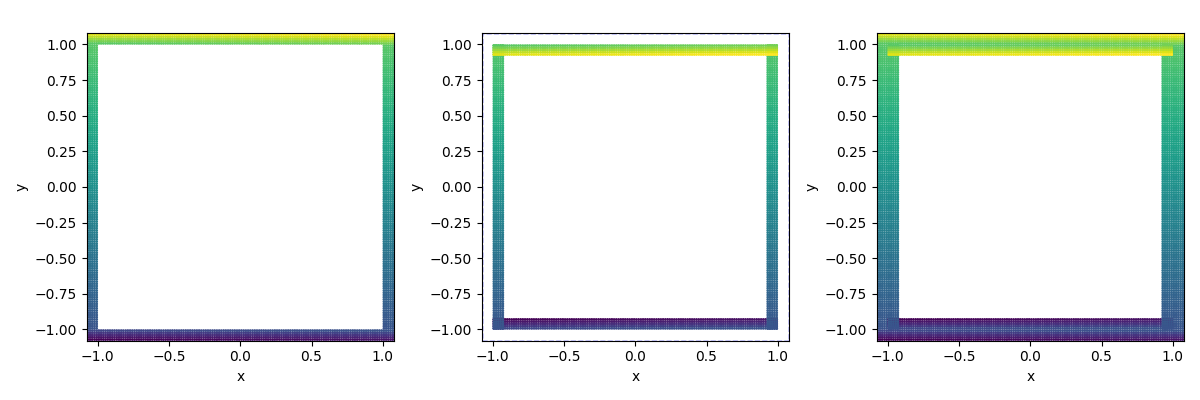

In [25]:
from diffSPH.v2.plotting import setPlotBaseAttributes
from diffSPH.v2.modules.mDBC import buildBoundaryGhostParticles

fig, axis = plt.subplots(1,3, figsize = (12,4), squeeze = False)

setPlotBaseAttributes(axis[0,0], config)
setPlotBaseAttributes(axis[0,1], config)
setPlotBaseAttributes(axis[0,2], config)

p = perennialState['boundary']['positions'].detach().cpu().numpy()

ghost =  buildBoundaryGhostParticles(perennialState, config)
g = ghost['positions'].detach().cpu().numpy()

axis[0,0].scatter(p[:,0], p[:,1], s = 1, c = np.arange(p.shape[0]))
axis[0,1].scatter(g[:,0], g[:,1], s = 1, c = np.arange(p.shape[0]))

axis[0,2].scatter(p[:,0], p[:,1], s = 1, c = np.arange(p.shape[0]))
axis[0,2].scatter(g[:,0], g[:,1], s = 1, c = np.arange(p.shape[0]))

fig.tight_layout()

In [26]:
perennialState['fluid']['velocities'] = velocity.clone()

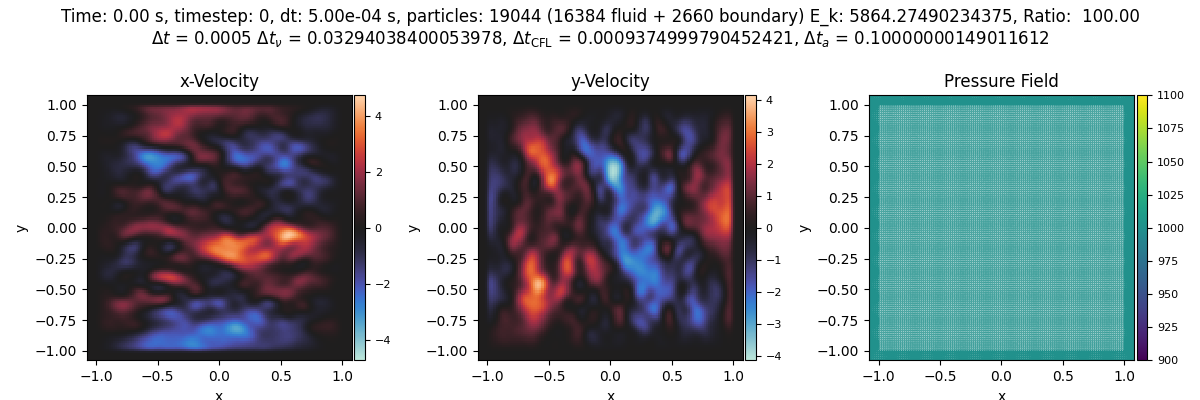

In [27]:
fig, axis = plt.subplots(1,3, figsize = (12,4), squeeze = False)

visualizationState = prepVisualizationState(perennialState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

s = 0.25

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
                                      'velocities',
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'icefire', title = 'x-Velocity', which = 'fluid', plotBoth = False, midPoint = 0)
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
                                      'velocities',
                                      mapping = '.y', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'icefire', streamLines = False, operation = None, title = 'y-Velocity', plotBoth = False, which = 'fluid', midPoint = 0)

l2Plot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
                                      'densities',
                                      mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'viridis', streamLines = False, operation = None, title = 'Pressure Field', plotBoth = False, which = 'both', midPoint = 0)



fig.tight_layout()

Ek_0 = 0.5 * perennialState['fluid']['masses'] * torch.sum(velocity**2, dim = 1)
Ek = 0.5 * perennialState['fluid']['masses'] * torch.sum(perennialState['fluid']['velocities']**2, dim = 1)

nu = config['diffusion']['alpha'] * config['fluid']['cs'] * config['particle']['support'] / (2 * (config['domain']['dim'] +2))
nu = config['diffusion']['nu'] if config['diffusion']['velocityScheme'] == 'deltaSPH_viscid' else nu
dt_v = 0.125 * config['particle']['support']**2 / nu / config['kernel']['kernelScale']**2
# acoustic timestep condition

dt_c = config['timestep']['CFL'] * config['particle']['support'] / config['fluid']['cs'] / config['kernel']['kernelScale']    
# print(dt_v, dt_c)

# acceleration timestep condition
if 'dudt' in perennialState['fluid']: 
    dudt = perennialState['fluid']['dudt']
    max_accel = torch.max(torch.linalg.norm(dudt[~torch.isnan(dudt)], dim = -1))
    dt_a = 0.25 * torch.sqrt(config['particle']['support'] / (max_accel + 1e-7)) / config['kernel']['kernelScale']
else:
    dt_a = torch.tensor(config['timestep']['maxDt'], dtype = dt_v.dtype, device = dt_v.device)


fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary) E_k: {Ek.sum()}, Ratio: {Ek.sum() / Ek_0.sum() * 100 : .2f}\n$\\Delta t$ = {perennialState["dt"]} $\\Delta t_\\nu$ = {dt_v}, $\\Delta t_\\text{{CFL}}$ = {dt_c}, $\\Delta t_a$ = {dt_a}')

fig.tight_layout()

In [28]:

print(Ek_0.sum(), Ek.sum())
print(Ek_0.sum() - Ek.sum())

tensor(5864.2749, device='cuda:0') tensor(5864.2749, device='cuda:0')
tensor(0., device='cuda:0')


In [29]:
jitter = torch.normal(mean = 0, std = config['particle']['dx'] * 0.01, size = [perennialState['fluid']['numParticles'], 2], device = perennialState['fluid']['positions'].device)

newState = copy.deepcopy(perennialState)
newState['fluid']['positions'] += jitter

In [30]:

from diffSPH.v2.modules.neighborhood import neighborSearch, searchNeighbors
with record_function("[SPH] - deltaSPH (1 - Neighbor Search)"):
    searchNeighbors(newState, config)

In [31]:
dx, _ = solveShifting(newState, config)
dx = dx * 100

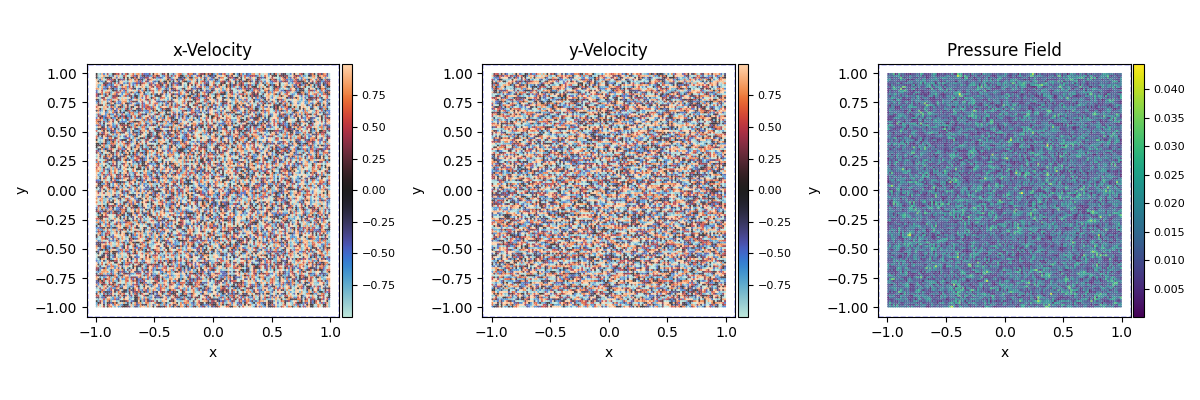

In [32]:
fig, axis = plt.subplots(1,3, figsize = (12,4), squeeze = False)

visualizationState = prepVisualizationState(perennialState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

s = 0.25

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
                                      dx[:,0] / (torch.linalg.norm(dx, dim = -1) + 1e-7),
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'icefire', title = 'x-Velocity', which = 'fluid', plotBoth = False, midPoint = 0)
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
                                      dx[:,1] / (torch.linalg.norm(dx, dim = -1) + 1e-7),
                                      mapping = '.y', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'icefire', streamLines = False, operation = None, title = 'y-Velocity', plotBoth = False, which = 'fluid', midPoint = 0)

l2Plot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
                                      dx,
                                      mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'viridis', streamLines = False, operation = None, title = 'Pressure Field', plotBoth = False, which = 'fluid', midPoint = 0)



fig.tight_layout()

In [33]:
fi, bj = newState['boundaryToFluidNeighborhood']['indices']

In [34]:
dx_fi = dx[fi]
n_bj = perennialState['boundary']['normals'][bj]

In [35]:
print(dx_fi)
print(n_bj)

dx_parallel_to_bdy = dx_fi - torch.sum(dx_fi * n_bj, dim = -1, keepdim = True) * n_bj
dx_orthogonal_to_bdy = torch.sum(dx_fi * n_bj, dim = -1, keepdim = True) * n_bj

print(dx_parallel_to_bdy)
print(dx_orthogonal_to_bdy)

tensor([[-0.0111, -0.0072],
        [-0.0111, -0.0072],
        [-0.0111, -0.0072],
        ...,
        [-0.0134, -0.0041],
        [-0.0134, -0.0041],
        [-0.0134, -0.0041]], device='cuda:0')
tensor([[ 0.5066,  0.8622],
        [ 0.8566,  0.5160],
        [ 0.7045,  0.7097],
        ...,
        [-0.7057, -0.7085],
        [-0.8562, -0.5166],
        [-0.5131, -0.8583]], device='cuda:0')
tensor([[-0.0051,  0.0030],
        [ 0.0002, -0.0004],
        [-0.0020,  0.0020],
        ...,
        [-0.0046,  0.0046],
        [-0.0017,  0.0029],
        [-0.0080,  0.0048]], device='cuda:0')
tensor([[-0.0060, -0.0102],
        [-0.0113, -0.0068],
        [-0.0091, -0.0092],
        ...,
        [-0.0087, -0.0088],
        [-0.0116, -0.0070],
        [-0.0053, -0.0089]], device='cuda:0')


In [36]:
from diffSPH.v2.compiler import compileSourceFiles

proj_cpp = compileSourceFiles(
    ['./cppSrc/vectorProjection.cpp', './cppSrc/vectorProjection.cu'], module_name = 'vectorProjection', verbose = False, openMP = True, verboseCuda = False, cuda_arch = None)
# from torch.utils.cpp_extension import load

# sphOperation_cpp = load(name='sphOperations', sources=['/home/winchenbach/dev/diffSPH/partiBench/cppOp.cpp'], verbose = True, with_cuda = False, is_python_module = False, extra_cflags = ['-fopenmp'], extra_ldflags = ['-fopenmp'])
project_cpp = proj_cpp.projectVectors

In [37]:
vectors_cpu = dx.cpu()
normals_cpu = newState['boundary']['normals'].cpu()
numBoundaryParticles = newState['boundary']['numParticles']
numFluidParticles = newState['fluid']['numParticles']

indices = newState['boundaryToFluidNeighborhood']['indices']
indices = (indices[0].cpu(), indices[1].cpu())
numNeighbors = newState['boundaryToFluidNeighborhood']['numNeighbors'].cpu()
neighborOffsets = newState['boundaryToFluidNeighborhood']['neighborOffsets'].cpu()

projected = project_cpp(vectors_cpu, normals_cpu, numBoundaryParticles, numFluidParticles, indices, numNeighbors, neighborOffsets)

print(projected, projected.shape)

tensor([[-1.0029e-25,  3.7940e-31],
        [ 3.0748e-25, -0.0000e+00],
        [-4.5955e-19,  0.0000e+00],
        ...,
        [ 2.3702e-19, -5.2486e-36],
        [-5.3009e-26,  5.2802e-26],
        [-1.6488e-25,  9.8563e-26]]) torch.Size([16384, 2])


In [38]:
vectors_cpu = dx
normals_cpu = newState['boundary']['normals']
numBoundaryParticles = newState['boundary']['numParticles']
numFluidParticles = newState['fluid']['numParticles']

indices = newState['boundaryToFluidNeighborhood']['indices']
indices = (indices[0], indices[1])
numNeighbors = newState['boundaryToFluidNeighborhood']['numNeighbors']
neighborOffsets = newState['boundaryToFluidNeighborhood']['neighborOffsets']
projected = project_cpp(vectors_cpu, normals_cpu, numBoundaryParticles, numFluidParticles, indices, numNeighbors, neighborOffsets)


In [39]:
print(vectors_cpu)
print(normals_cpu)
print(numBoundaryParticles)
print(numFluidParticles)
print(indices)
print(numNeighbors)
print(neighborOffsets)

tensor([[-0.0111, -0.0072],
        [ 0.0190, -0.0013],
        [-0.0138, -0.0029],
        ...,
        [ 0.0081, -0.0046],
        [-0.0041, -0.0115],
        [-0.0134, -0.0041]], device='cuda:0')
tensor([[ 0.7063,  0.7080],
        [ 0.6127,  0.7903],
        [ 0.4860,  0.8739],
        ...,
        [-0.4840, -0.8750],
        [-0.6159, -0.7878],
        [-0.7073, -0.7069]], device='cuda:0')
2660
16384
(tensor([    0,     0,     0,  ..., 16383, 16383, 16383], device='cuda:0'), tensor([ 279,  416,  417,  ..., 2242, 2243, 2380], device='cuda:0'))
tensor([30, 26, 22,  ..., 22, 26, 30], device='cuda:0', dtype=torch.int32)
tensor([    0,    30,    56,  ..., 18246, 18268, 18294], device='cuda:0',
       dtype=torch.int32)


In [40]:

projected = project_cpp(vectors_cpu, normals_cpu, numBoundaryParticles, numFluidParticles, indices, numNeighbors, neighborOffsets)



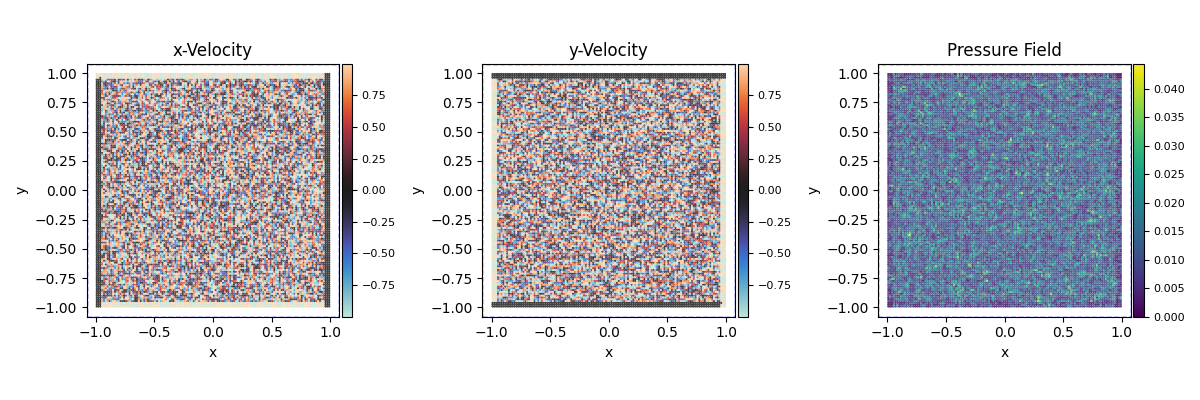

In [41]:
fig, axis = plt.subplots(1,3, figsize = (12,4), squeeze = False)

visualizationState = prepVisualizationState(perennialState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

s = 0.25

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
                                      projected[:,0] / (torch.linalg.norm(projected, dim = -1) + 1e-7),
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'icefire', title = 'x-Velocity', which = 'fluid', plotBoth = False, midPoint = 0)
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
                                      projected[:,1] / (torch.linalg.norm(projected, dim = -1) + 1e-7),
                                      mapping = '.y', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'icefire', streamLines = False, operation = None, title = 'y-Velocity', plotBoth = False, which = 'fluid', midPoint = 0)

l2Plot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
                                      projected,
                                      mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=False, cmap = 'viridis', streamLines = False, operation = None, title = 'Pressure Field', plotBoth = False, which = 'fluid', midPoint = 0)



fig.tight_layout()

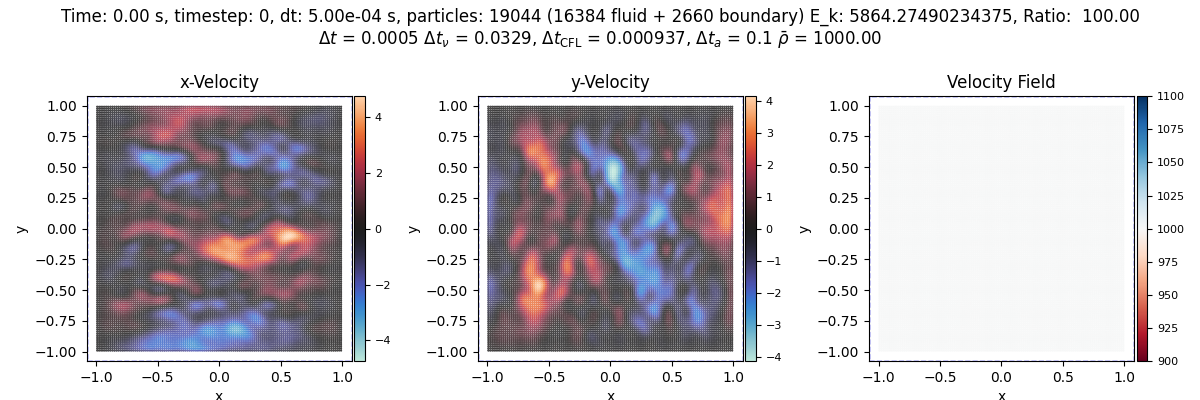

In [42]:
fig, axis = plt.subplots(1,3, figsize = (12,4), squeeze = False)

visualizationState = prepVisualizationState(perennialState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

s = 0.25

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
                                      'velocities',
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'icefire', title = 'x-Velocity', which = 'fluid', plotBoth = False, midPoint = 0)
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
                                      'velocities',
                                      mapping = '.y', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'icefire', streamLines = False, operation = None, title = 'y-Velocity', plotBoth = False, which = 'fluid', midPoint = 0)

l2Plot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
                                      'densities',
                                      mapping = 'L2', s = s, 
                          scaling = 'sym', gridVisualization=False, cmap = 'RdBu', streamLines = False, operation = None, title = 'Velocity Field', plotBoth = False, which = 'fluid', midPoint = 1000)



fig.tight_layout()

Ek_0 = 0.5 * perennialState['fluid']['masses'] * torch.sum(velocity**2, dim = 1)
Ek = 0.5 * perennialState['fluid']['masses'] * torch.sum(perennialState['fluid']['velocities']**2, dim = 1)

nu = config['diffusion']['alpha'] * config['fluid']['cs'] * config['particle']['support'] / (2 * (config['domain']['dim'] +2))
nu = config['diffusion']['nu'] if config['diffusion']['velocityScheme'] == 'deltaSPH_viscid' else nu
dt_v = 0.125 * config['particle']['support']**2 / nu / config['kernel']['kernelScale']**2
# acoustic timestep condition

dt_c = config['timestep']['CFL'] * config['particle']['support'] / config['fluid']['cs'] / config['kernel']['kernelScale']    
# print(dt_v, dt_c)

# acceleration timestep condition
if 'dudt' in perennialState['fluid']: 
    dudt = perennialState['fluid']['dudt']
    max_accel = torch.max(torch.linalg.norm(dudt[~torch.isnan(dudt)], dim = -1))
    dt_a = 0.25 * torch.sqrt(config['particle']['support'] / (max_accel + 1e-7)) / config['kernel']['kernelScale']
else:
    dt_a = torch.tensor(config['timestep']['maxDt'], dtype = dt_v.dtype, device = dt_v.device)


fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary) E_k: {Ek.sum()}, Ratio: {Ek.sum() / Ek_0.sum() * 100 : .2f}\n$\\Delta t$ = {perennialState["dt"]} $\\Delta t_\\nu$ = {dt_v:.3g}, $\\Delta t_\\text{{CFL}}$ = {dt_c:.3g}, $\\Delta t_a$ = {dt_a:.3g} $\\bar\\rho$ = {perennialState["fluid"]["densities"].mean():.2f}')

fig.tight_layout()

In [43]:
from diffSPH.v2.plotting import exportPlot, postProcessPlot
from diffSPH.v2.simulationSchemes.deltaPlus import checkNaN

priorState = None
for i in tqdm(range(4096)):
    if 'shiftAmount' in perennialState['fluid']:
        del perennialState['fluid']['shiftAmount']
    perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
    dx, _ = solveShifting(perennialState, config)
    perennialState['fluid']['shiftAmount'] = dx

    # dx[torch.unique(perennialState['boundaryToFluidNeighborhood']['indices'][0]),:] = 0
    # vectors_cpu = dx
    # normals_cpu = perennialState['boundary']['normals']
    # numBoundaryParticles = perennialState['boundary']['numParticles']
    # numFluidParticles = perennialState['fluid']['numParticles']

    # indices = perennialState['boundaryToFluidNeighborhood']['indices']
    # indices = (indices[0], indices[1])
    # numNeighbors = perennialState['boundaryToFluidNeighborhood']['numNeighbors']
    # neighborOffsets = perennialState['boundaryToFluidNeighborhood']['neighborOffsets']
    # dx = project_cpp(vectors_cpu, normals_cpu, numBoundaryParticles, numFluidParticles, indices, numNeighbors, neighborOffsets)



    numNeighbors = perennialState['fluid']['neighborhood']['numNeighbors']
    perennialState['fluid']['positions'][numNeighbors > 5] += dx[numNeighbors > 5]

    if config['compute']['checkNaN']:
        checkNaN(perennialState['fluid']['positions'], 'positions')
        checkNaN(perennialState['fluid']['shiftAmount'], 'shiftAmount')
    
    # perennialState = simulationStep(perennialState, config)
    # perennialState['fluidGhostParticles'] = buildOutletGhostParticles(regions, perennialState, config)


    perennialState['time'] += config['timestep']['dt']
    perennialState['timestep'] += 1
    # fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary)')
    # perennialState['fluid']['positions'] += perennialState['fluid']['velocities'] * config['timestep']['dt']

    Ek = 0.5 * perennialState['fluid']['masses'] * torch.sum(perennialState['fluid']['velocities']**2, dim = 1)
    state = perennialState
    nu = config['diffusion']['alpha'] * config['fluid']['cs'] * config['particle']['support'] / (2 * (config['domain']['dim'] +2))
    nu = config['diffusion']['nu'] if config['diffusion']['velocityScheme'] == 'deltaSPH_viscid' else nu
    dt_v = 0.125 * config['particle']['support']**2 / nu / config['kernel']['kernelScale']**2
    # acoustic timestep condition

    dt_c = config['timestep']['CFL'] * config['particle']['support'] / config['fluid']['cs'] / config['kernel']['kernelScale']    
    # print(dt_v, dt_c)

    # acceleration timestep condition
    if 'dudt' in state['fluid']: 
        dudt = state['fluid']['dudt']
        max_accel = torch.max(torch.linalg.norm(dudt[~torch.isnan(dudt)], dim = -1))
        dt_a = 0.25 * torch.sqrt(config['particle']['support'] / (max_accel + 1e-7)) / config['kernel']['kernelScale']
    else:
        dt_a = torch.tensor(config['timestep']['maxDt'], dtype = dt_v.dtype, device = dt_v.device)

    fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary) E_k: {Ek.sum()}, Ratio: {Ek.sum() / Ek_0.sum() * 100 : .2f}\n$\\Delta t$ = {perennialState["dt"]} $\\Delta t_\\nu$ = {dt_v:.3g}, $\\Delta t_\\text{{CFL}}$ = {dt_c:.3g}, $\\Delta t_a$ = {dt_a:.3g} $\\bar\\rho$ = {perennialState["fluid"]["densities"].mean():.2f}')
    # fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary) E_k: {Ek.sum()}, Ratio: {Ek.sum() / Ek_0.sum() * 100 : .2f}\n$\\Delta t$ = {perennialState["dt"]} $\\Delta t_\\nu$ = {dt_v}, $\\Delta t_\\text{{CFL}}$ = {dt_c}, $\\Delta t_a$ = {dt_a}')
    # print(dt_v, dt_c, dt_a)
    # fig.suptitle(f'Time: {perennialState["time"]:.2f} s, timestep: {perennialState["timestep"]}, dt: {perennialState["dt"]:.2e} s, particles: {perennialState["fluid"]["numParticles"] + perennialState["boundary"]["numParticles"]} ({perennialState["fluid"]["numParticles"]} fluid + {perennialState["boundary"]["numParticles"]} boundary) E_k: {Ek.sum()}, Ratio: {Ek.sum() / Ek_0.sum() * 100 : .2f}')
    if i % 10 == 0:
        # printState(perennialState)
        # print(f'Iteration {i}')
        visualizationState = prepVisualizationState(perennialState, config)
        updatePlot(indexPlot, visualizationState, 'velocities')
        updatePlot(quantPlot, visualizationState, 'velocities')
        updatePlot(l2Plot, visualizationState, 'densities')
        fig.canvas.draw()
        fig.canvas.flush_events()
        exportPlot(perennialState, config, fig)

    for emitter in config['regions']:
        if emitter['type'] == 'inlet':
            processInlet(perennialState, emitter)
        if emitter['type'] == 'outlet':
            processOutlet(emitter, config, perennialState)
        if emitter['type'] == 'forcing':
            processForcing(emitter, config, perennialState)


  0%|          | 0/4096 [00:00<?, ?it/s]

In [44]:

import subprocess
import shlex

outFile = config['plot']['namingScheme'] if config['plot']['namingScheme'] != 'timestep' else config["simulation"]["timestamp"]
if config['plot']['namingScheme'] == 'timestep':
    outFolder = f'{config["plot"]["exportPath"]}/{config["simulation"]["timestamp"]}/'
else:
    outFolder = f'{config["plot"]["exportPath"]}/{config["plot"]["namingScheme"]}/'

os.makedirs(outFolder, exist_ok = True)
# print('Creating video from  frames (frame count: {})'.format(len(os.listdir(outFolder))))
command = '/usr/bin/ffmpeg -loglevel warning -y -framerate 30 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r ' + str(config['plot']['exportFPS']) + ' ' + outFolder + 'output.mp4'
commandB = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -vf "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos,palettegen" output/palette.png'
commandC = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -i output/palette.png -filter_complex "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos[x];[x][1:v]paletteuse" {outFile}.gif'

subprocess.run(shlex.split(command))
subprocess.run(shlex.split(commandB))
subprocess.run(shlex.split(commandC))

[Parsed_palettegen_2 @ 0x5731a589e000] Dupped color: FFCCCCCC


CompletedProcess(args=['ffmpeg', '-loglevel', 'warning', '-hide_banner', '-y', '-i', 'output/2024_06_26-14_30_48/output.mp4', '-i', 'output/palette.png', '-filter_complex', 'fps=30,scale=640:-1:flags=lanczos[x];[x][1:v]paletteuse', '2024_06_26-14_30_48.gif'], returncode=0)